# Лабораторная работа №2
# Вариант №3
## В работе численно решается уравнение Релея, переписанное ввиде системы ОДУ
$$
\left\{\begin{gathered}x1'=x2\\x2'=1000\,\left(1-x2^{2}\right)\,x2-x1\\x1(0)=0\\ x2(0)=0.001\end{gathered}\right.
$$

## Был использован метод Розенброка 3 порядка точности.



In [10]:
import numpy as np
from matplotlib import pyplot as plt

h = 1e-3
initial_condition = np.array([[0], [0.001]])

def Riley(t, x):
    x1 = x[0][0]
    x2 = x[1][0]
    x1_new = x2
    x2_new = 1000 * (1 - x2 ** 2) * x2 - x1
    return np.array([[x1_new], [x2_new]])

def Deriv3Order(f, x, h):
    return (4 / 3 * (f(x + h) - f(x - h)) / 2 / h - 1 / 3 * (f(x + 2 * h) - f(x - 2 * h)) / 4 / h)

def NewtonMethod(start, F, J, epsilon=1e-6, funcJacobian=True):
    curr_x = start
    prev_x = start

    while True:
        if funcJacobian:
            curr_x = curr_x - np.matmul(np.linalg.inv(J(curr_x)), F(curr_x))
        else:
            curr_x = curr_x - np.matmul(np.linalg.inv(J), F(curr_x))
        if normVec(curr_x - prev_x) < epsilon:
            break
        prev_x = curr_x

    return curr_x

a = 0.435866521508459
beta_21 = a
beta_31 = a

beta    = a * (6 * a * a - 3 * a + 2) / (6 * a * a - 6 * a + 1)

beta_32 = beta - a
p_1 = a
p_3 = (6 * a * a - 6 * a + 1) / (6 * a * (beta - a))
p_2 = (1 - 2 * a - 2 * beta * p_3) / (2 * a)



def normVec(V):
    norm = 0.0
    for i in range(0, V.shape[0]):
        norm = max(norm, np.abs(float(V[i])))

    return norm


def UpperRelaxation(A, f, start, w=1.5, epsilon=1e-6):
    n = A.shape[0]
    
    D = np.zeros([n, n])
    L = np.zeros([n, n])
    U = np.zeros([n, n])

    prev_x = start
    curr_x = start

    for i in range(0, n):
        for j in range(0, n):
            if i > j:
                L[i, j] = A[i, j]
            elif i < j:
                U[i, j] = A[i, j]
            else:
                D[i, j] = A[i, j]

    ### This matrix is (D + wL)^-1
    M = np.linalg.inv(D + w * L)

    ### This matrix is (D + wL)^-1 * [(w-1)D + wU]
    V = np.matmul(M, (w - 1) * D + w * U)

    while normVec(f - np.matmul(A, curr_x)) >= epsilon:
        prev_x = curr_x
        curr_x = -np.matmul(V, prev_x) + np.matmul(w * M, f)

    return curr_x


def CalcMatrixForRosenbrock(x_n, y_n, h, f):
    Len = len(y_n)
    Jac = np.empty([Len, Len])
    for i in range(0, Len):
        for j in range(0, Len):
            def F_i(y):
                return f(x_n, y)[i, 0]


            def dFi_dyj(y):
                def F_i_of_y_j(y_j):
                    tmp = np.concatenate((y[:j], [[y_j]], y[(j+1):]))
                    return F_i(tmp)

                return Deriv3Order(F_i_of_y_j, y[j, 0], h)

            Jac[i, j] = dFi_dyj(y_n)

    return np.identity(Len) - a * h * Jac


def Rosenbrock3Order(x_n, y_n, h, f):
    D_n = CalcMatrixForRosenbrock(x_n, y_n, h, f)

    b_1 = h * f(x_n, y_n)
    k_1 = UpperRelaxation(D_n, b_1, y_n)

    b_2 = h * f(x_n + beta_21 * h, y_n + beta_21 * k_1)
    k_2 = UpperRelaxation(D_n, b_2, k_1)

    b_3 = h * f(x_n + (beta_31 + beta_32) * h, y_n + beta_31 * k_1 + beta_32 * k_2)
    k_3 = UpperRelaxation(D_n, b_3, k_2)

    return y_n + p_1 * k_1 + p_2 * k_2 + p_3 * k_3

In [11]:
def draw_result(t, xs, ys):
    fig, ax = plt.subplots(figsize=[30, 8])
    plt.subplot(121)
    plt.plot(t, xs,  linewidth=2, label='X')
    plt.plot(t, ys, linewidth=2, label='Y')
    plt.title('Riley', fontsize=24)
    plt.xlabel('Time, с', fontsize=20)
    plt.ylabel('Concentration', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(which='major', linestyle='-')
    plt.legend()
    plt.subplot(122)
    plt.plot(xs, ys, color='red')
    plt.title('Phase tragectory', fontsize=24)
    plt.xlabel('X', fontsize=20)
    plt.ylabel('Y', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(which='major', linestyle='-')
    plt.grid(which='minor', linestyle='--', linewidth=0.1)
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_4860\2857781302.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


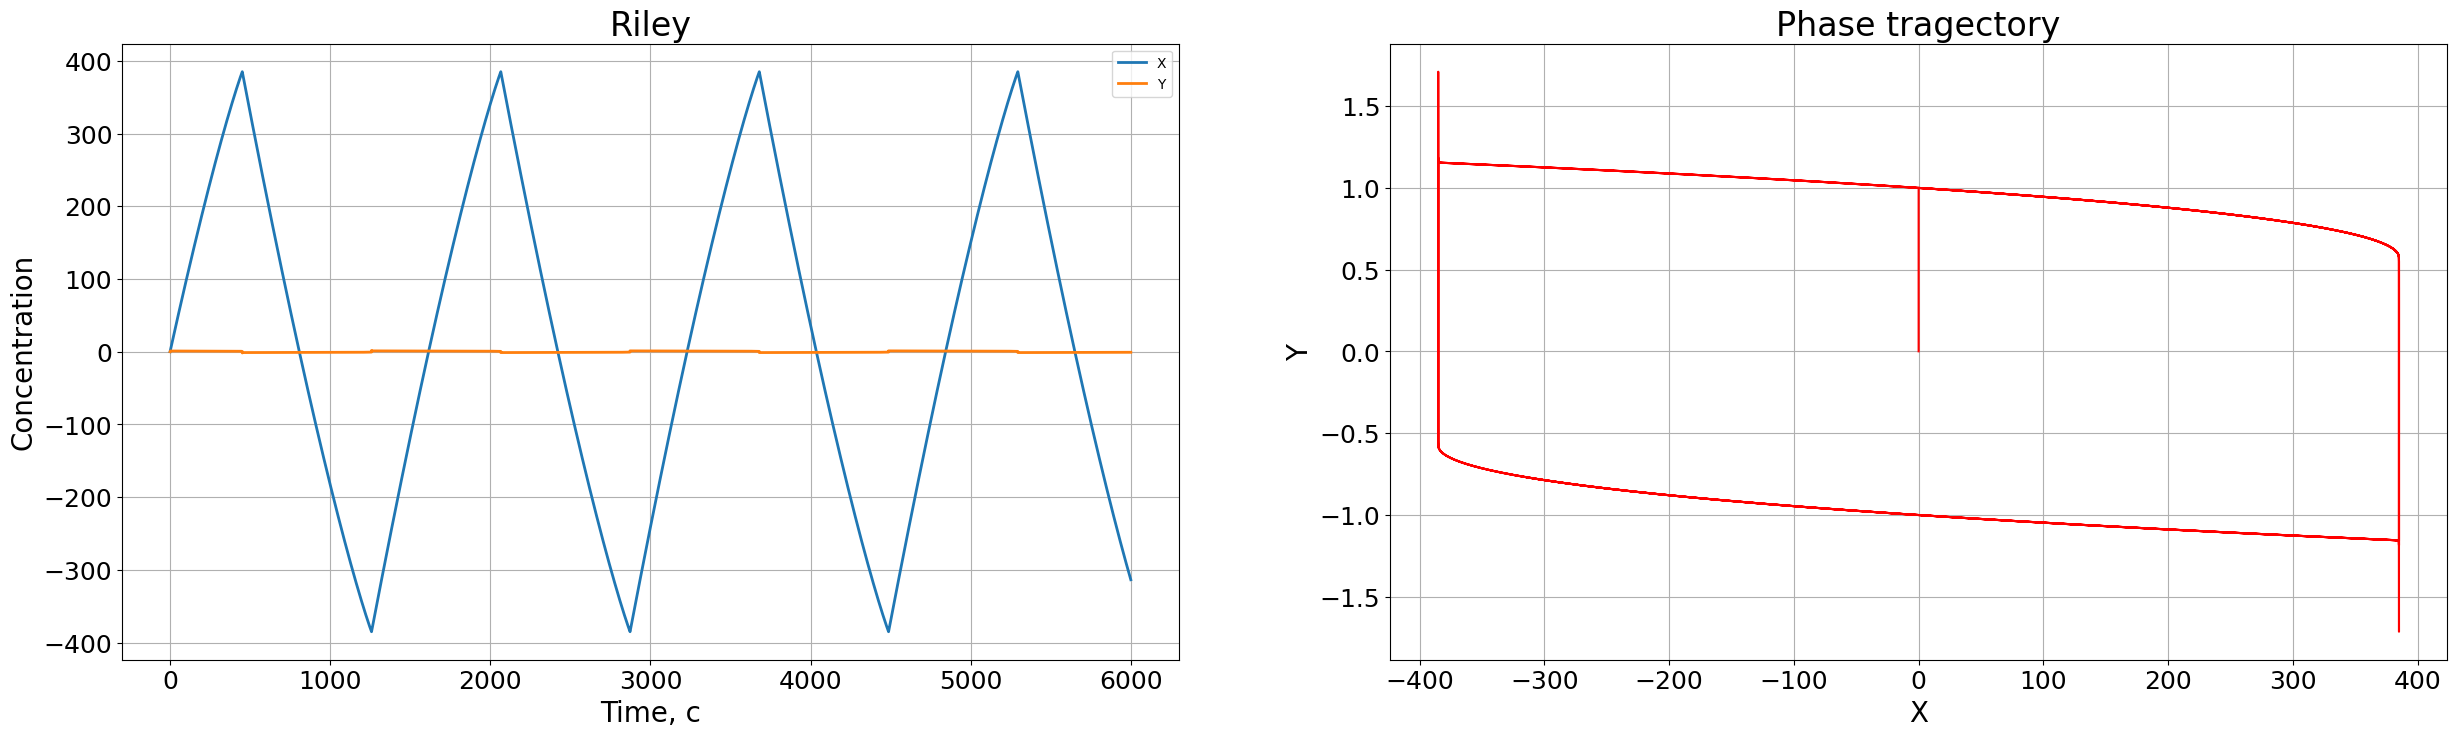

In [12]:
t = [0.0]
solution = [initial_condition]

for i in range(6000000):
    iteration = Rosenbrock3Order(t[i], solution[i], h, Riley)
    solution.append(iteration)
    t.append(h * (i + 1))

x1 = []
x2 = []
for point in solution:
    x1.append(point[0][0])
    x2.append(point[1][0])

draw_result(t, x1, x2)

## Видно, что решение периодическое